<a href="https://colab.research.google.com/github/cagutierrezgu/My_Portfolio/blob/main/Clothes%20image%20classification/EDA/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data understanding and exploration

En primer lugar se importarán las librerías necesarias para llevar a cabo el proyecto descrito, las cuales incluyen herramientas para la visualización y tratamiento de imágenes, así como para la implementación de modelos de aprendizaje supervisado y no supervisado sobre dichas imágenes. Para realizar lo anterior, importamos:

In [ ]:
# Vista general de las librerías a usar
import sklearn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Métodos específicos para los modelos a realizar
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split
# Reducción de dimensión para visualización
from sklearn.manifold import TSNE
# Métricas para evaluar los modelos a entrenar
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score


import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

A continuación leemos los dataframes a usar, los cuales pueden descargarse desde la página de [Kaggle](https://www.kaggle.com/datasets/zalando-research/fashionmnist?select=fashion-mnist_train.csv), los cuales corresponden a un conjunto de datos de entrenamiento y prueba ya seleccionados:

In [ ]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')
train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


El anterior es el dataframe con las imágenes de entrenamiento de dimensión (60000, 785), es decir, contiene 60000 imágenes para entrenamiento las cuales están escritas como un vector de 784 componentes, que teniendo en cuenta que se trata de imágenes cuadradas, indica que estas son de dimensión (28, 28). De lo anterior puede afirmarse que se trabajará con $28\times28 = 784$ pixeles, además la columna restante contiene las etiquetas de cada imagen, la prenda de vestir correspondiente representada numéricamente de 0 a 9 y cuyo significado se muestra en la siguiente lista respectivamente:

In [ ]:
labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Ahora, es necesario separar las imágenes de sus etiquetas y almacenarlas en arreglos de numpy por conveniencia. Además, debido a que se cuenta con un número de datos bastante elevado, se trabajará con una fracción de dichos datos y así evitar largos tiempos de espera en los modelos a realizar, por lo tanto tomamos la décima parte de los datos de cada dataframe:

In [ ]:
y_train = np.array([(train['label'])])[0][:6000]
x_train = np.array(train.drop('label', axis = 1))[:6000]
x_train.shape, y_train.shape

((6000, 784), (6000,))

In [ ]:
y_test = np.array([(test['label'])])[0][:1000]
x_test = np.array(test.drop('label', axis = 1))[:1000]
x_test.shape, y_test.shape

((1000, 784), (1000,))

Una vez se tienen los conjuntos de prueba y entrenamiento para los posteriores entrenamientos, resulta interesante ver gráficamente algunas de las imágenes con las que están trabajando, para lo cual es necesario redimensionar los arreglos que contienen las imágenes:

In [ ]:
x_train_reshaped = np.array([img.reshape(28,28) for img in x_train])
x_test_reshaped = np.array([img.reshape(28,28) for img in x_test])
x_train_reshaped.shape

(6000, 28, 28)

Lo que permite ver algunas de las imágenes en discusión:

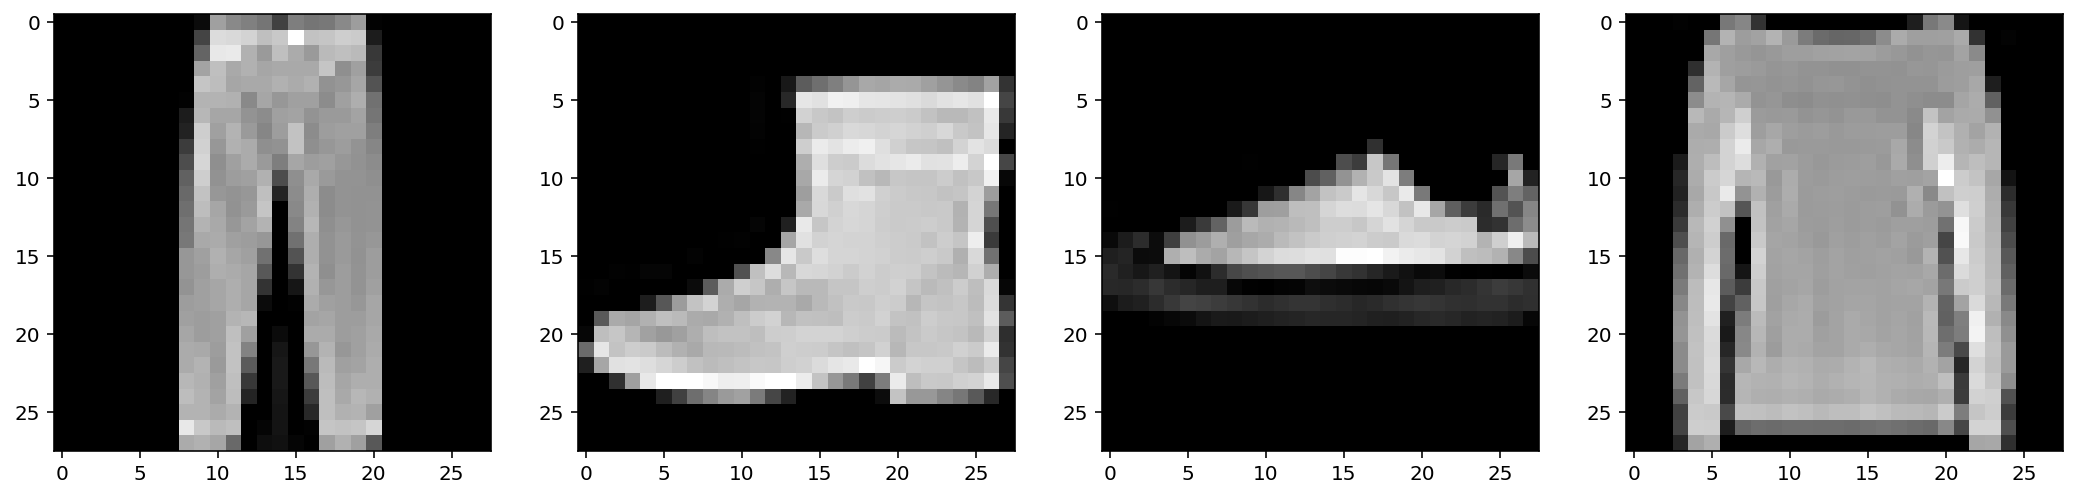

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(18,10))

random = np.random.randint(0, len(x_train), (4))
for i in range(len(random)):
    axes[i].imshow(x_train_reshaped[random[i]], cmap = 'gray');

A pesar de que los conjuntos de datos originales tenían la ventaja de brindar conjuntos de prueba y entrenamiento para ser usados en modelos de aprendizaje automático, se unirán dichos conjuntos para una posterior representación del conjunto de datos en su totalidad al aplicar el método de t-SNE, luego las formas de los nuevos arreglos serán:

In [ ]:
x = [i for i in x_train]
for i in x_test:
    x.append(i)
x = np.array(x)
x.shape

(7000, 784)

In [ ]:
y = [i for i in y_train]
for i in y_test:
    y.append(i)
y = np.array(y)
y.shape

(7000,)

Uno de los aspectos importantes a revisar en los nuevos conjuntos de datos es la distribución de estos respecto a sus etiquetas, ya que varias celdas atrás se escogieron las primeras 6000 y 1000 imágenes del conjunto de prueba y entrenamiento respectivamente, las cuales contenían imágenes con etiquetas distribuidas aleatoriamente. Es por lo anterior que es necesario revisar si existen pocas o muchas imágenes de una determinada etiqueta, ya que podría alterar futuros resultados en los modelos:

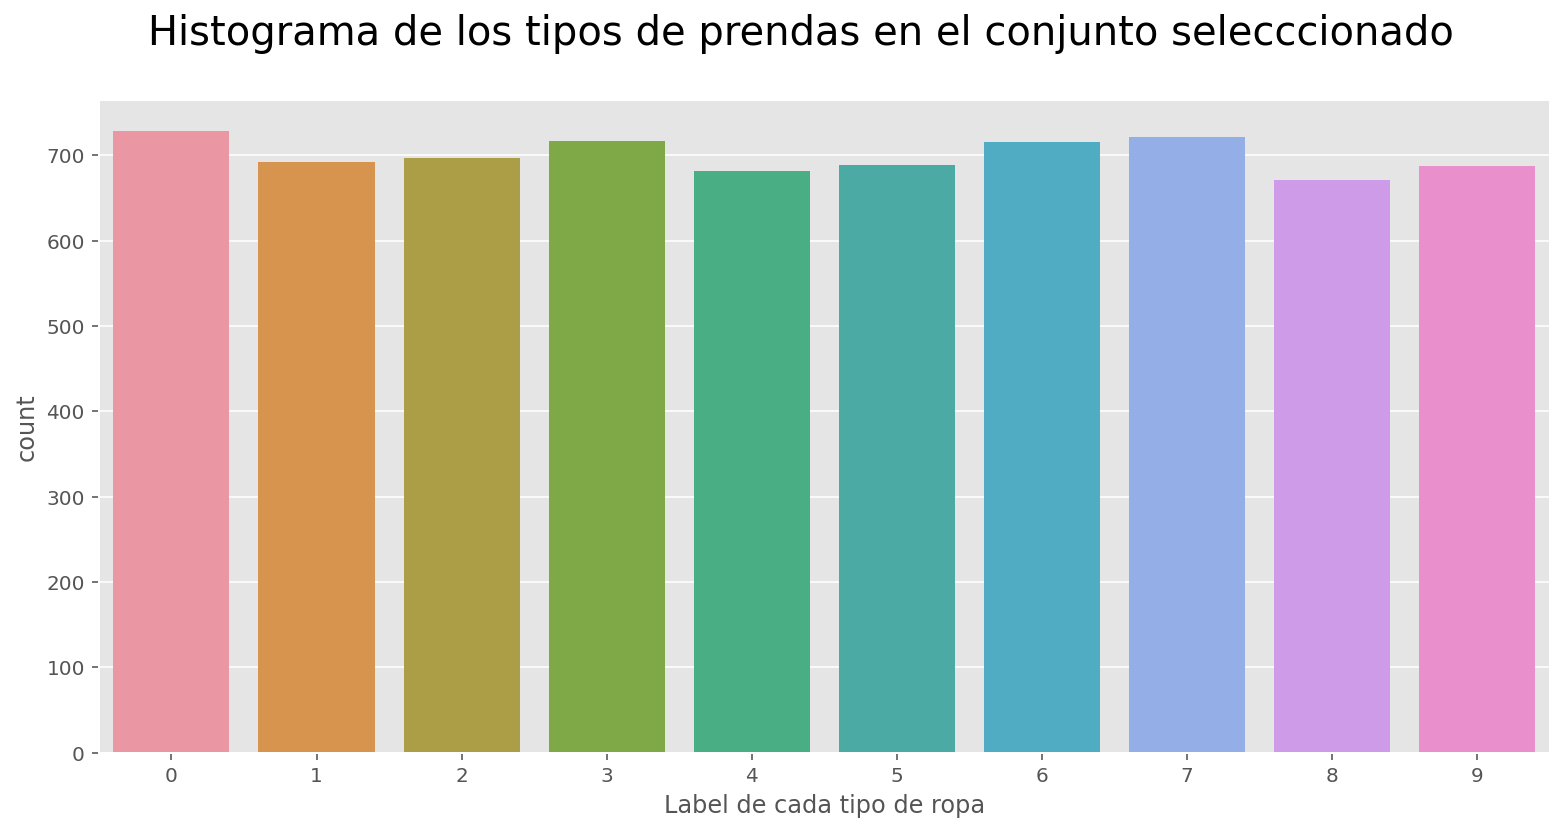

In [ ]:
plt.figure(figsize=(13,6))
plt.style.use('ggplot');
sns.countplot(x = y)
plt.xlabel('Label de cada tipo de ropa')
plt.suptitle('Histograma de los tipos de prendas en el conjunto selecccionado', fontsize = 20);

El histograma permite ver que existen algunas diferencias en el número de imágenes de algunas etiquetas, pero no son de un tamaño considerable que derive en problemas a la hora de implementar modelos de aprendizaje o clasificación. 

Otra de las acciones a realizar sobre el conjunto de las imágenes es la normalización de los valores de los pixeles, ya que este varía de 0 a 255, así que se modifica dicho intervalo a (0,1):

In [ ]:
x = x.astype('float32')
x = x/255.0

Una vez realizadas las tareas anteriores, resulta útil para la visualización de los datos dispuestos aplicar el método de t-SNE sobre la totalidad de las imágenes, ya que dicho método al igual que PCA, son especiales para la reducción de la dimensionalidad, con algunas diferencias entre las que está que PCA es un algoritmo de tipo lineal y puede no detectar u obviar dependencias de otro tipo, las cuales no pasan por alto en t-SNE. A continuación se aplica t-SNE sobre las imágenes para verlas representadas en 2 dimensiones:

In [ ]:
tsne = TSNE(
    n_components=2,
    )
T = tsne.fit_transform(x)

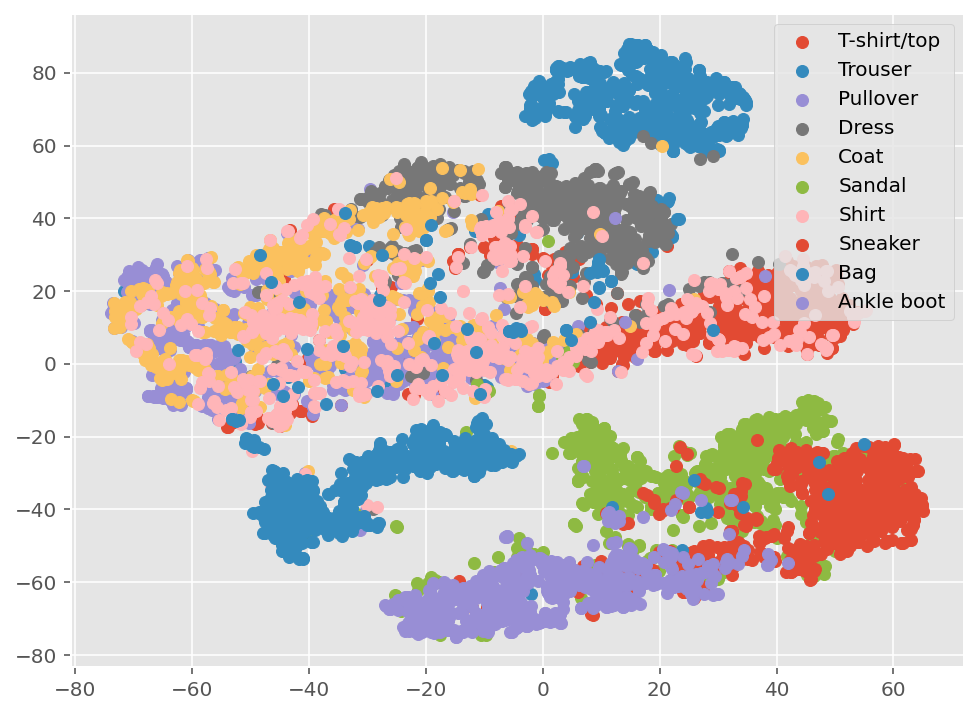

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

a = 0
for label in labels:
    current_tx = np.take(T[:, 0], [i for i in range(len(y)) if y[i]==a])
    current_ty = np.take(T[:, 1], [i for i in range(len(y)) if y[i]==a])
    a += 1
    ax.scatter(current_tx, current_ty, label=label)

ax.legend(loc='best')

plt.show()

La anterior muestra las imágenes representadas por puntos en 2 dimensiones, algunas categorías formando clusters, pero de manera general distribuidas por todo el plano visible en la imagen.